# Jupyter Notebook für die Analyse von Infinium MethylationEPIC v2.0 BeadChip-Daten in R

## Die ChIP Analysis Methylation Pipeline (ChAMP)
Nachdem der Lab-Part der Methylierungsanalyse abgeschlossen ist, erhalten wir als Bioinformatiker*innen Datensätze zusammengesetzt aus einem Saplesheet und mehreren .idat Files, die Fluoreszenzsignale enthalten. Um diese Fluoreszenzsignale (binäres Dateiformat) auslesen und mit dem Samplesheet verknüpfen zu können, greifen wir auf bereits existierende Software zurück. In diesem Fall analysieren wir usnere Daten mit der ChIP Analysis Methylation Pipeline (ChAMP). Diese Pipeline basiert auf R und kombiniert bekannte Software für veschiedene Parts der Methylierungsnalyse (minfi, combat, bumphunter), um eine umfassende Pipeline zur Verfügung zu stellen.

ChAMP unterscheidet bei fast allen Funktionen zwischen drei Typen von Methylierungsarrays, da Illumina über die Jahre verschiedene Arrayversionen veröffentlicht hat. Die älteren Versionen sind 450k- und EPICv1-Arrays, die sich hauptsächlich in der Menge der enthaltenen CpGs unterscheiden. Dieses Notebook ist darauf ausgelegt, die Analyse von EPICv2-Arrays (die aktuellste Version) zu zeigen.

Die hier durchgeführten Schritte umfassen:
1) Einlesen und Filtern der Daten
2) Normalisierung der Methylierungslevel
3) Überprüfung auf und Entfernen von Batch-Effekten
4) Vergleich der Methylierung zwischen Zellproben

### Import aller nötigen R Pakete

In [1]:
# import all needed R packages
library(ChAMP)
library(ChAMPdata)
library(ggplot2)
library(stringr)
library(ggpubr)

Lade nötiges Paket: minfi

Lade nötiges Paket: BiocGenerics

Lade nötiges Paket: generics


Attache Paket: ‘generics’


Die folgenden Objekte sind maskiert von ‘package:base’:

    as.difftime, as.factor, as.ordered, intersect, is.element, setdiff,
    setequal, union



Attache Paket: ‘BiocGenerics’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    IQR, mad, sd, var, xtabs


Die folgenden Objekte sind maskiert von ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, saveRDS, table, tapply, unique,
    unsplit, which.max, which.min


Lade nötiges Paket: GenomicRanges

Lade nötiges Paket: stats4

Lade nötiges Paket: S4Vectors


Attache Paket: ‘S4Vectors’


Das folgende Objekt ist maskiert ‘package:utils’:

In [2]:
# where are you located inside the notebook?
# useful (but not mandatory) for tracing the path/to/samplesheet.csv
getwd()

[1] "/home/niklas/Promotion/methylom_analysis/methylome_masterclass_notebooks/analysis_notebooks"

In [3]:
# set the location of the experiment directory
# the .idat fluorescence files and the samplesheet.csv have to be located inside the directory and it's subdirectories
epicv2_dir <- "../example_datasets/epicv2/data"

### Setzen des Datenverzeichnisses, Laden und Filtern der Daten
<img controls src="../images/steps_7.png" />
</img>

Alle Daten müssen für die Verarbeitung mit ChAMP in einem Verzeichnis abgelegt werden. Das Verzeichnis enthält sowohl alle .idat Dateien (jeweils grün und rot pro Probe), als auch das Samplesheet. ChAMP sucht initial eine .csv Datei, die als Samplesheet gelesen wird (bei mehr als einer .csv Dateien treten Probleme auf), liest daraus Sentrix_ID und Sentrix_Position, und sucht anhand dieser Informationen die .idat Dateien benannt in der Form *Sentrix_ID*_*Sentrix_position*_Grn.idat und *Sentrix_ID*\_*Sentrix_position*\_Red.idat.

Die Fluoreszenzsignale werden daraufhin ausgelesen und daraus je nach benötigtem Methylierungswert (**methValue**) Beta oder M Werte berechnet. Zusätzlich wird eine Reihe von Filtern angewendet, die folgende Sonden aus den Datensätzen entfernen:
1) Sonden, die nicht signifikant methyliert oder demethyliert sind (die sich nicht signifikant vom Hintergrundsignal unterscheiden)
2) Sonden, die nicht die Methylierung von CpGs überprüfen 
3) Sonden, die in der Nähe von single nucleotide polymorphisms (SNPs) liegen
4) Sonden, die auf mehrere genomische Regionen mappen
5) Sonden, die auf dem X- und Y-Chromosom liegen
6) Sonden, in denen der Anteil der Proben mit weniger als 3 Beads über **beadCutoff** liegt

Zusätzlich werden Proben entfernt, in denen mindestens **SampleCutoff** Sonden durch vorherige Filterungsschritte entfernt wurden.
Alle **fett** gedruckten Begriffe sind Argumente der unten stehenden `champ.load` Funktion

Der Stdout und Stderr enthält von ChAMP sehr viele nützliche Informationen zu Datensatz und Filterprozess. So kann man beispielsweise sehen, wie viele Sonden in den verschiedenen Filterungsschritten entfernt wurden und, ob Proben entfernt wurden (abhängig von **SampleCutoff**).

In [5]:
# champ.load searches for a samplesheet file and all .idat files listed in samplesheet, extracts fluorescence values
myLoad <- champ.load(directory = epicv2_dir,
                     method="ChAMP", # replaces old loading method using minfi
                     methValue="B", # wether to calculate beta- or M-values
                     autoimpute=TRUE, # if values are missing uses the 3 most similar probes and uses the mean of their values for the missing value 
                     filterDetP=TRUE, # filter single probes, whose methylation signal vs the background signal of the slide is not significant (detPcut)
                     ProbeCutoff=0, # remove all probes with higher missing-value-ratio
                     SampleCutoff=0.1, # remove a full sample if the failed probe ratio (based on p value) is higher than this threshold
                     detPcut=0.01, # significance p-value cutoff for filterDetP
                     filterBeads=TRUE, # filter out probes if the fraction of samples with a beadcount < 3 is higher than beadCutoff
                     beadCutoff=0.05, # acceptable fraction of samples with a beadcount < 3
                     filterNoCG=TRUE, # wether to remove non-cg probes
                     filterSNPs=TRUE, # wether to remove probes that fallnear a SNP (as defined in Nordlund et al. https://link.springer.com/article/10.1186/s13059-021-02529-2                       ) 
                     population=NULL, # can be assigned to specific population according to www.internationalgenome.org/category/population/
                     filterMultiHit=TRUE, # wether to remove probes that align to multiple genomic locations (also according to Nordlund et al.)
                     filterXY=TRUE, # wether to remove probes on x and y chromosomes
                     force=FALSE, # minfi specific parameter
                     arraytype="EPICv1") # microarray type (can be one of "450K" "EPICv1" or "EPICv2") 

[===========================]

[<<<< ChAMP.LOAD START >>>>>]

-----------------------------


[ Loading Data with ChAMP Method ]

----------------------------------

Note that ChAMP method will NOT return rgSet or mset, they object defined by minfi. Which means, if you use ChAMP method to load data, you can not use SWAN or FunctionNormliazation method in champ.norm() (you can use BMIQ or PBC still). But All other function should not be influenced.


[===========================]

[<<<< ChAMP.IMPORT START >>>>>]

-----------------------------


[ Section 1: Read PD Files Start ]

  CSV Directory: ../example_datasets/epicv2/data/Demo_EPIC-8v2-0_A1_SampleSheet_16.csv

  Find CSV Success

  Reading CSV File

  Replace Sentrix_Position into Array

  Replace Sentrix_ID into Slide

[ Section 1: Read PD file Done ]



[ Section 2: Read IDAT files Start ]

  Loading:../example_datasets/epicv2/data/206891110001/206891110001_R01C01_Grn.idat ---- (1/16)

  Loading:../example_datasets/epicv2/data/2

ERROR: Error in champ.import(directory, arraytype = arraytype):   Meth Matrix and UnMeth Matrix seems not paried correctly.


### Qualitätskontrolle des Datensatzes vor der Normalisierung
<img controls src="../images/steps_8.png" />
</img>

Das Objekt *MyLoad* enthält, je nach *methValue* Beta- oder M-Werte für alle Sonden und Proben, die nach der Filterung übrig sind. Nach dem Filterungsprozess sollten die Daten visualisiert werden, um eine erste Qualitätskontrolle durchführen zu können.

`champ.QC` erstellt uns aus dem Datensatz einen MDS-Plot, einen Density-Plot von Beta- oder M-Werten und ein Dendrogramm der Proben.

**MDS-Plot**: Ähnlich einer Principal component analysis (PCA) dient der MDS-Plot dazu, die Daten pro Probe in einen niedrigdimensionalen Raum zu projezieren. Für jede Probe bleiben zwei Werte übrig, die die Unterschiede zwischen den Proben bestmöglich beschreiben. Im Idealfall sollten Replikate sehr stark Clustern und die Samplegroups sollten in den meisten Fällen gut separiert sein.

**Density-Plot**: Da die DNA, die wir auf die Microarrays geben aus einer Population von Zellen (keiner Einzelzelle) stammt, zeigt uns die Fluoreszenz die durchschnittliche Methylierung einer Menge von Zellen. Der Density-Plot zeigt die Dichteverteilung der Beta-Werte (Methylierung) pro Probe. Die hier dargestellten Kurven sollten eine Badewannen-Form haben: Zwei klare Peaks, der eine um 0, der andere um 1. Zwischen den beiden Peaks sollte die Kurve relativ flach sein. Diese Form ist zu erwarten, da wir annehmen, dass die Methylierung der meisten CpGs in einer Probe über mehrere Zellen gleich sein sollte - entweder methyliert oder unmethyliert.

**Dendrogramm**: Das Dendrogramm hat eine ähnliche Funktion, wie der MDS-Plot. Hier werden alle Proben ihrer Ähnlichkeit entsprechend aufgetrennt. Die Länge des Weges zwischen zwei Proben spiegelt die Ähnlichkeit der Proben wieder. Hier ist zu erwarten, dass eine klare Separation der Proben zwischen den Samplegroups und Replikate stattfindet.

In allen Plots kann schon jetzt überprüft werden, ob die Samplegroups sich in Dendrogramm und MDS-Plot gut separieren. Das muss nicht immer der Fall sein, abhängig von den zu erwartenden Unterschieden in der Methylierung zwischen Samplegroups.

Wenn die Auftrennung der Proben in Samplegroups unerwartet schwach ist, kann dies darauf hindeuten, dass zwischen den Proben nur kleine Unterschiede in der Methylierung vorliegen. Wenn die Auftrennung der Replikate unerwartet groß sein sollte, kann dies darauf hindeuten, dass es im experimentellen Ablauf zu Batch-Effekten kam (mehr Info hierzu im Kapitel **Erkennen und Entfernen von Batch Effekten**). Um das genauer zu betrachten, könnt ihr pheno anpassen, um Auftrennungen nach anderen Spalten eures Samplesheets zu betrachten.

[===========================]

[<<<<< ChAMP.QC START >>>>>>]

-----------------------------

champ.QC Results will be saved in ./CHAMP_QCimages/

[QC plots will be proceed with 847956 probes and 8 samples.]


<< Prepare Data Over. >>

<< plot mdsPlot Done. >>




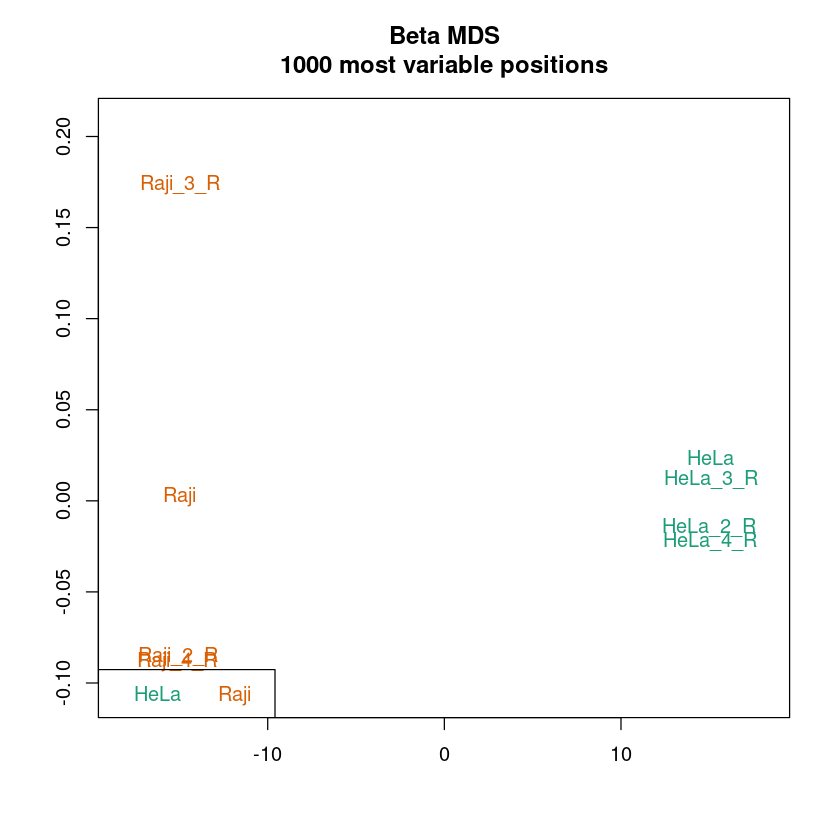

<< Plot densityPlot Done. >>


< Dendrogram Plot Feature Selection Method >: No Selection, directly use all CpGs to calculate distance matrix.



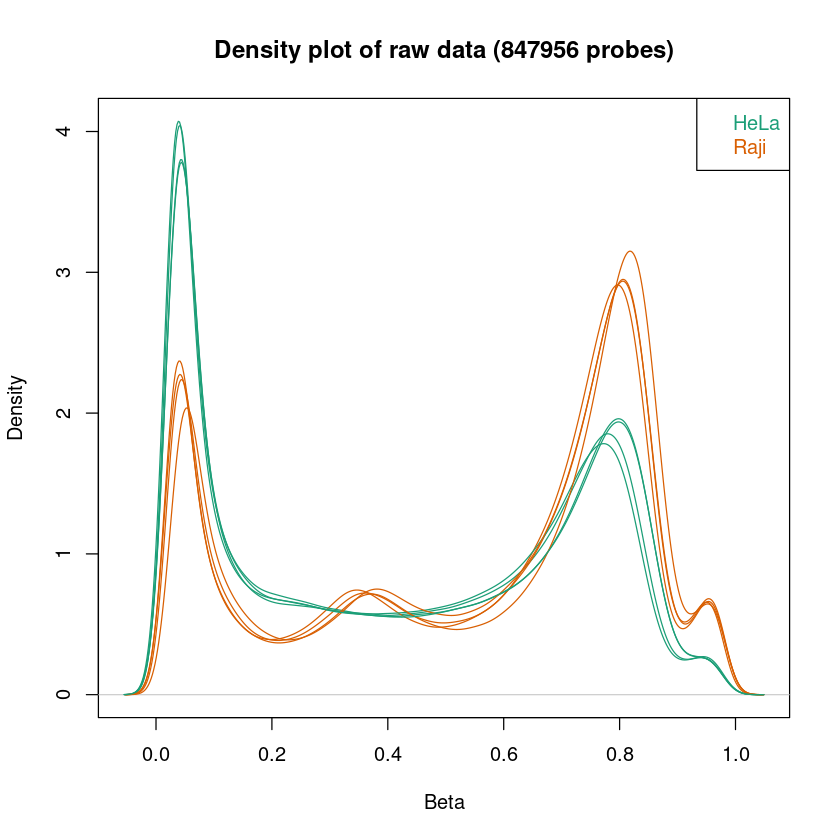

<< Plot dendrogram Done. >>


[<<<<<< ChAMP.QC END >>>>>>>]

[===========================]

[You may want to process champ.norm() next.]




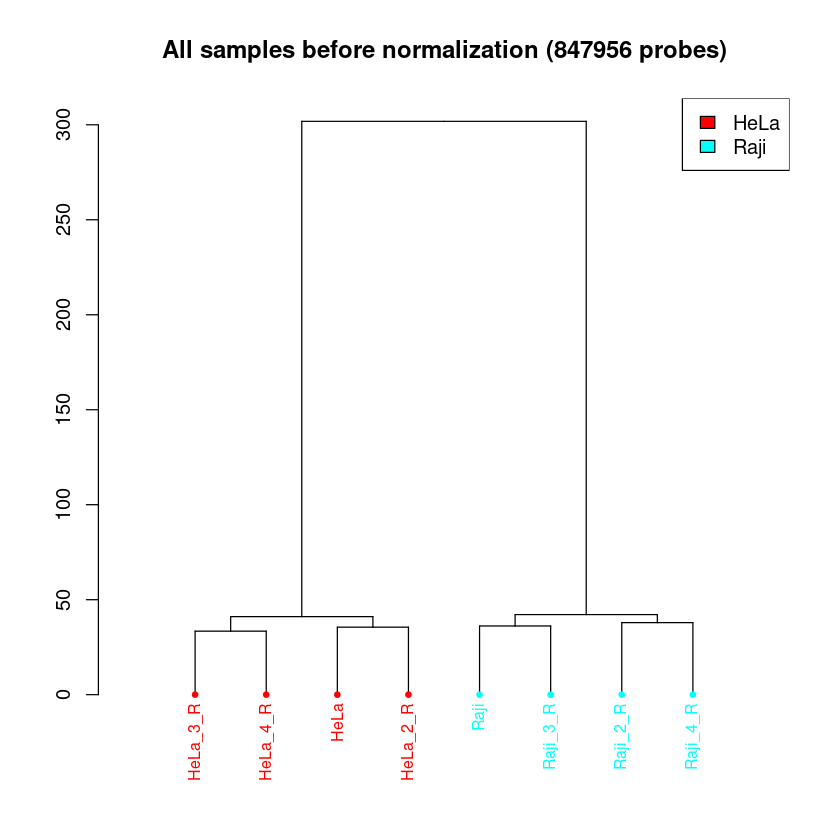

In [9]:
champ.QC(beta = myLoad$beta, # beta values stored in champ.load output
         pheno=myLoad$pd$Sample_Group, # what samplesheet column is your phenotype (where do u expect the major difference between your samples)?
         resultsDir="./CHAMP_QCimages/") # the plots will be saved in the directory this notebook file is located in

### Normalisierung mit anschließender Evaluation
Nachdem wir die Daten im oberen Abschnitt eingelesen und gefiltert haben, werden diese normalisiert, um die Vergleichbarkeit der Daten zu verbessern, ohne sie zu verfälschen. Dafür vergleichen wir den Effekt der Normalisierung durch PBC und BMIQ (unterschiedliche Normalisierungsmethoden). ChAMP bietet zusätzlich funktionale Normalisierung und SWAN, diese beruhen allerdings auf rgset und mset, weshalb wir sie an dieser Stelle nicht nutzen können.

Nach jeder Normalisierung nutzen wir erneut `champ.QC`, um eine Qualitätskontrolle durchzuführen. Am Ende entscheiden wir uns für die Normalisierung mit der besten Separation und der besten Badewanne.

[===========================]

[>>>>> ChAMP.NORM START <<<<<<]

-----------------------------

champ.norm Results will be saved in ./CHAMP_Normalization/

[ SWAN method call for BOTH rgSet and mset input, FunctionalNormalization call for rgset only , while PBC and BMIQ only needs beta value. Please set parameter correctly. ]


<< Normalizing data with PBC Method >>



[1] "Done for sample 1"
[1] "Done for sample 2"
[1] "Done for sample 3"
[1] "Done for sample 4"
[1] "Done for sample 5"
[1] "Done for sample 6"
[1] "Done for sample 7"
[1] "Done for sample 8"


[>>>>> ChAMP.NORM END <<<<<<]

[===========================]

[You may want to process champ.SVD() next.]


[===========================]

[<<<<< ChAMP.QC START >>>>>>]

-----------------------------

champ.QC Results will be saved in ./CHAMP_QCimages/PBC/

[QC plots will be proceed with 847956 probes and 8 samples.]


<< Prepare Data Over. >>

<< plot mdsPlot Done. >>




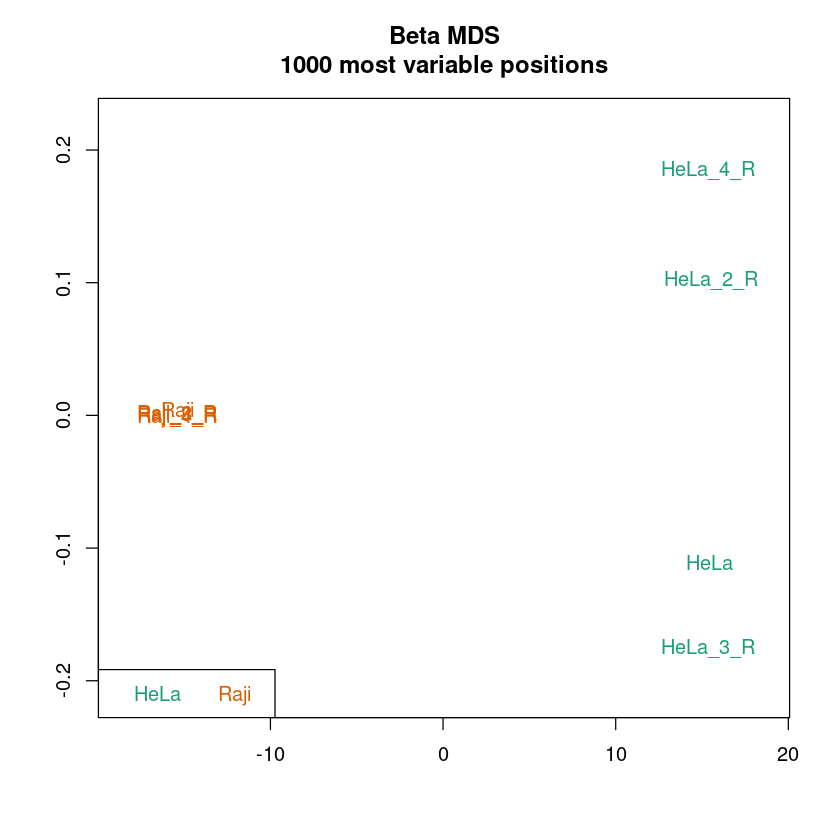

<< Plot densityPlot Done. >>


< Dendrogram Plot Feature Selection Method >: No Selection, directly use all CpGs to calculate distance matrix.



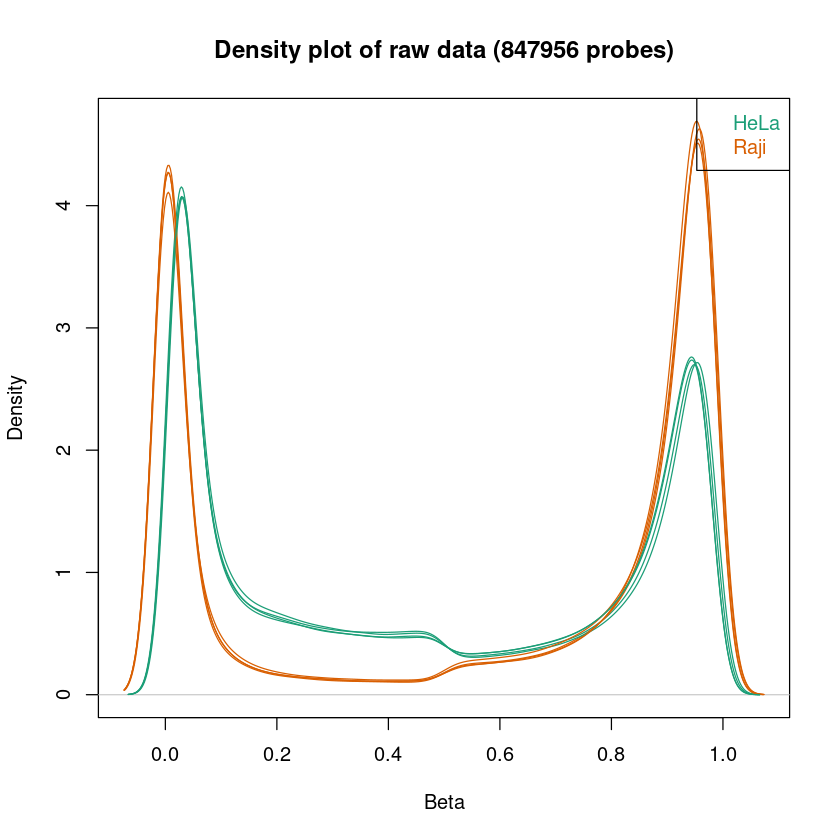

<< Plot dendrogram Done. >>


[<<<<<< ChAMP.QC END >>>>>>>]

[===========================]

[You may want to process champ.norm() next.]




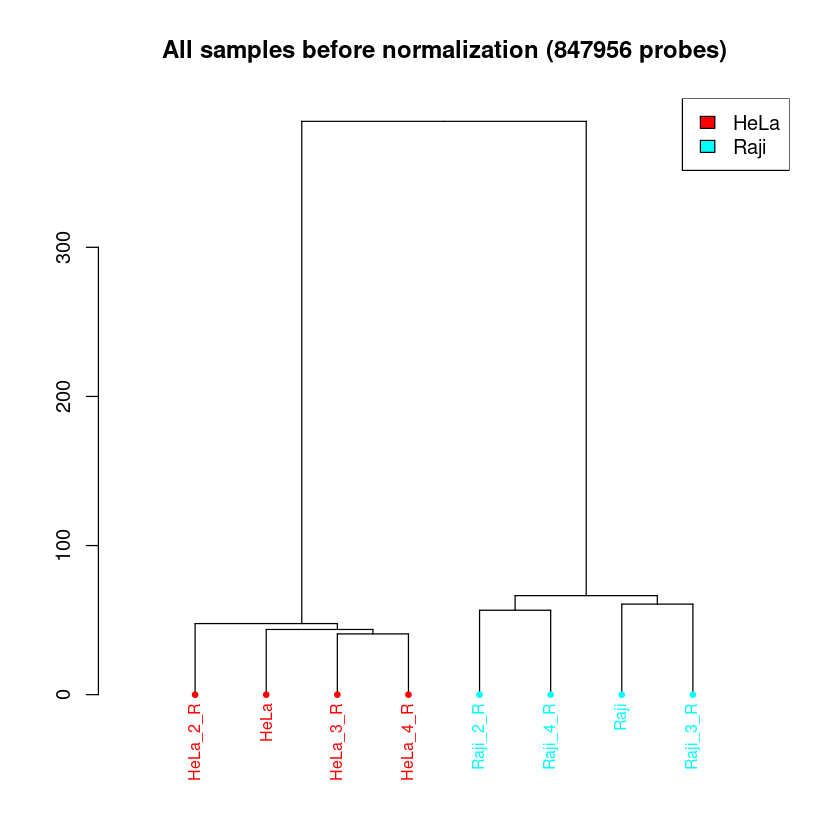

In [6]:
# start with PBC normalization
myNormPBC <- champ.norm(beta = myLoad$beta, arraytype = "EPICv2", method = "PBC")
champ.QC(beta = myNormPBC, pheno = myLoad$pd$Sample_Group, resultsDir = "./CHAMP_QCimages/PBC/")

[===========================]

[>>>>> ChAMP.NORM START <<<<<<]

-----------------------------

champ.norm Results will be saved in ./CHAMP_Normalization/

[ SWAN method call for BOTH rgSet and mset input, FunctionalNormalization call for rgset only , while PBC and BMIQ only needs beta value. Please set parameter correctly. ]


<< Normalizing data with BMIQ Method >>

Note that,BMIQ function may fail for bad quality samples (Samples did not even show beta distribution).

3 cores will be used to do parallel BMIQ computing.

[>>>>> ChAMP.NORM END <<<<<<]

[===========================]

[You may want to process champ.SVD() next.]


[===========================]

[<<<<< ChAMP.QC START >>>>>>]

-----------------------------

champ.QC Results will be saved in ./CHAMP_QCimages/BMIQ/

[QC plots will be proceed with 847956 probes and 8 samples.]


<< Prepare Data Over. >>

<< plot mdsPlot Done. >>




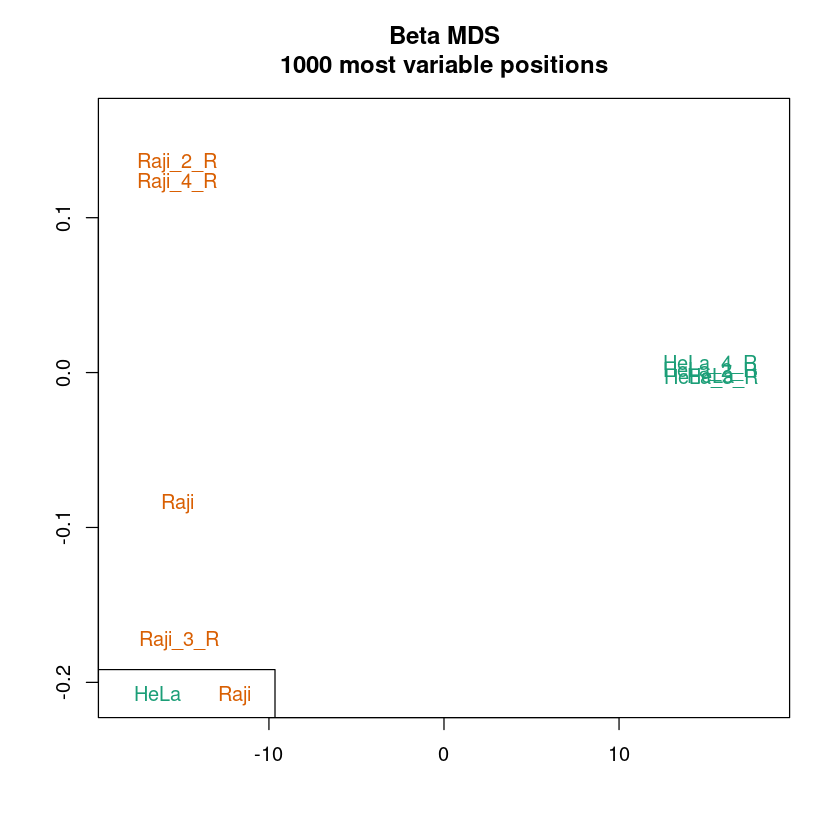

<< Plot densityPlot Done. >>


< Dendrogram Plot Feature Selection Method >: No Selection, directly use all CpGs to calculate distance matrix.



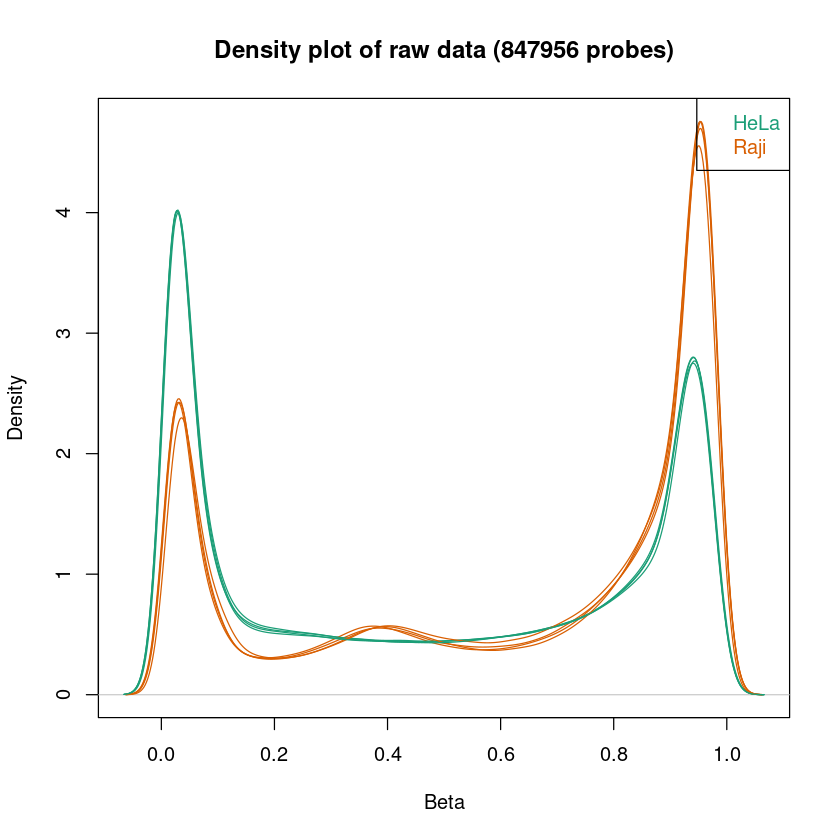

<< Plot dendrogram Done. >>


[<<<<<< ChAMP.QC END >>>>>>>]

[===========================]

[You may want to process champ.norm() next.]




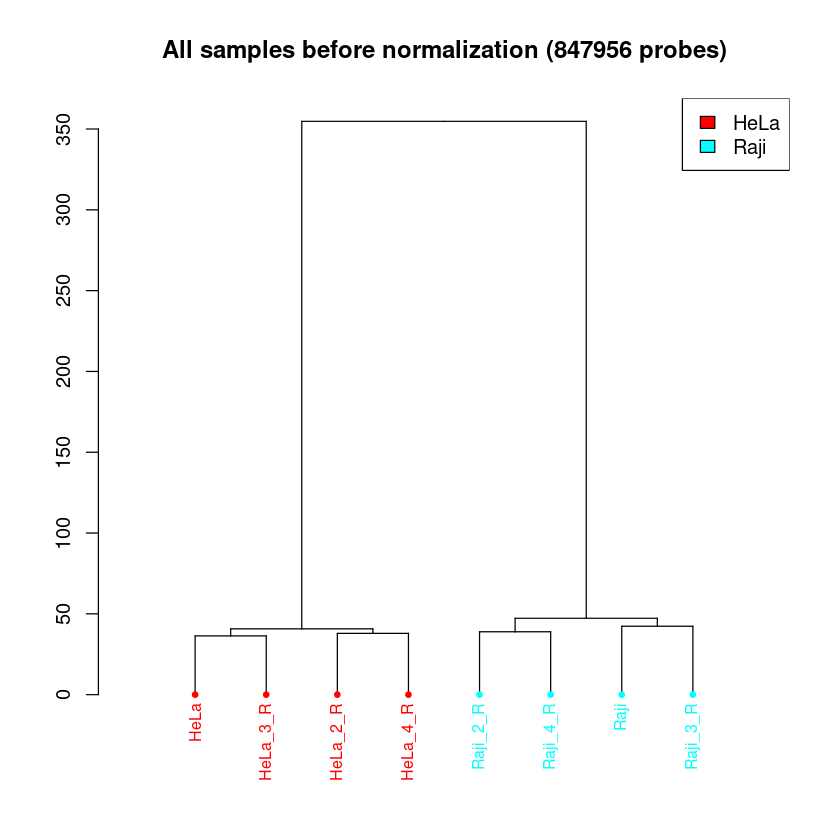

In [7]:
# BMIQ normalization
myNormBMIQ <- champ.norm(beta = myLoad$beta, arraytype = "EPICv2", method = "BMIQ")
champ.QC(beta = myNormBMIQ, pheno=myLoad$pd$Sample_Group, resultsDir="./CHAMP_QCimages/BMIQ/")

In [8]:
# save best looking normalization result
myNorm <- myNormBMIQ

### Erkennen und Entfernen von Batch Effekten
<img controls src="../images/steps_9.png" />
</img>

Es kann vorkommen, dass Daten selbst nach der Normalisierung noch nicht perfekt aussehen. "Nicht perfekt" bezieht sich hierbei auf erkennbare Unterschiede zwischen Proben, zwischen denen keine Unterschiede zu erwarten sind. Das können beispielsweise Replikate desselben Gewebes sein, die sich im MDS-Plot auftrennen.

In solchen Fällen kann die Ursache bei Batch-Effekten liegen. Als Batch-Effekt bezeichnet man (nicht zwingend erklärbare) Unterschiede in der durchschnittlichen Fluoreszenz zwischen verschiedenen Beadchips, Positionen auf dem Beadchip oder beispielsweise Tagen, an denen Experimente durchgeführt wurden.

Um diese Effekte zu finden, wird das Samplesheet und alle darin stehenden Gruppierungsspalten genutzt, um nach Unterschieden zwischen Gruppen zu suchen. Zu diesen Gruppen gehören Sample_Group, Sentrix_ID, Sentrix_Position und Pool_ID (falls ausgefüllt).

`champ.SVD` erstellt einen SVD Plot, in dem erkennbar ist, wie stark verschiedene Gruppierungsparameter mit Varianz zwischen den Proben (wiedergespiegelt durch die ersten drei Hauptkomponenten PC-1, PC-2 und PC-3) assoziiert sind. Alle bunten Blöcke sind dabei statistisch signifikant (p < 0.05) und sollten berücksichtigt werden mit Ausnahme der Blöcke für Samplegroup.

Nach Feststellung von Batch-Effekten kann `champ.runCombat` genutzt werden, um die gefundenen Batch-Effekte zu entfernen.

Zur Auswertung dient ein weiterer SVD-Plot.

[===========================]

[<<<<< ChAMP.SVD START >>>>>]

-----------------------------

champ.SVD Results will be saved in ./CHAMP_SVDimages/ .


[SVD analysis will be proceed with 847956 probes and 8 samples.]



[ champ.SVD() will only check the dimensions between data and pd, instead if checking if Sample_Names are correctly matched (because some user may have no Sample_Names in their pd file),thus please make sure your pd file is in accord with your data sets (beta) and (rgSet).]


<< Following Factors in your pd(sample_sheet.csv) will be analysised: >>

<Sample_Group>(character):HeLa, Raji

<Slide>(character):206891110001, 206891110002, 206891110004, 206891110005

<Array>(character):R01C01, R07C01, R04C01, R06C01

[champ.SVD have automatically select ALL factors contain at least two different values from your pd(sample_sheet.csv), if you don't want to analysis some of them, please remove them manually from your pd variable then retry champ.SVD().]


<< Following Factors in yo

Sample_Group,Slide,Array
0.02092134,0.9188914,0.1037772


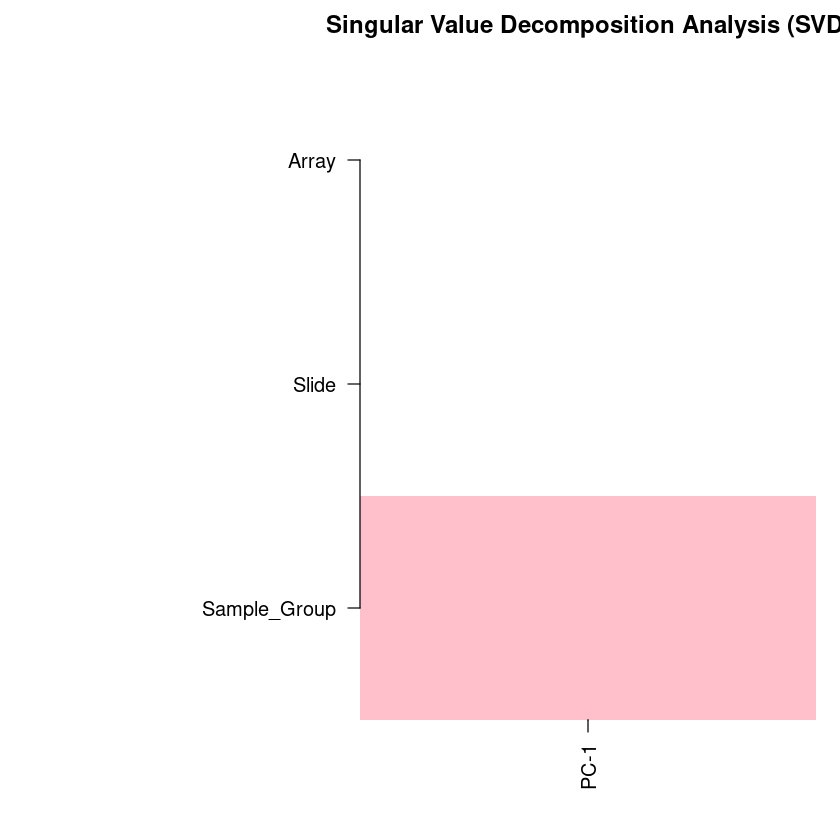

In [10]:
champ.SVD(beta=myNorm,pd=myLoad$pd)

In [12]:
myCombat <- champ.runCombat(beta=myNorm,pd=myLoad$pd,batchname=c("Array"))

[===========================]

[<< CHAMP.RUNCOMBAT START >>]

-----------------------------

<< Preparing files for ComBat >>

[Combat correction will be proceed with 832552 probes and 16 samples.]


<< Following Factors in your pd(sample_sheet.csv) could be applied to Combat: >>

<Sample_Name>(character)

<Slide>(character)

<Array>(character)

[champ.runCombat have automatically select ALL factors contain at least two different values from your pd(sample_sheet.csv).]


<< Following Factors in your pd(sample_sheet.csv) can not be corrected: >>

<Sample_Well>

<Sample_Plate>

<Sample_Group>

<Pool_ID>

[Factors are ignored because they are conflict with variablename, or they contain ONLY ONE value across all Samples, or some phenotype contains less than 2 Samples.]

As your assigned in batchname parameter: Array will be corrected by Combat function.


<< Start Correcting Array >>



~Sample_Group
<environment: 0x5b32c2cf56a8>


Generate mod success. Started to run ComBat, which is quite slow...



Found 4 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found7batches

Adjusting for1covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


champ.runCombat success. Corrected dataset will be returned.



[===========================]

[<<<<< ChAMP.SVD START >>>>>]

-----------------------------

champ.SVD Results will be saved in ./CHAMP_SVDimages/ .


[SVD analysis will be proceed with 832552 probes and 16 samples.]



[ champ.SVD() will only check the dimensions between data and pd, instead if checking if Sample_Names are correctly matched (because some user may have no Sample_Names in their pd file),thus please make sure your pd file is in accord with your data sets (beta) and (rgSet).]


<< Following Factors in your pd(sample_sheet.csv) will be analysised: >>

<Sample_Group>(character):Cellline, Coriell

<Slide>(character):206891110001, 206891110002, 206891110004, 206891110005

<Array>(character):R01C01, R03C01, R07C01, R08C01, R02C01, R04C01, R06C01

[champ.SVD have automatically select ALL factors contain at least two different values from your pd(sample_sheet.csv), if you don't want to analysis some of them, please remove them manually from your pd variable then retry champ.SVD(

Sample_Group,Slide,Array
0.003609347,0.9074465,0.4049149


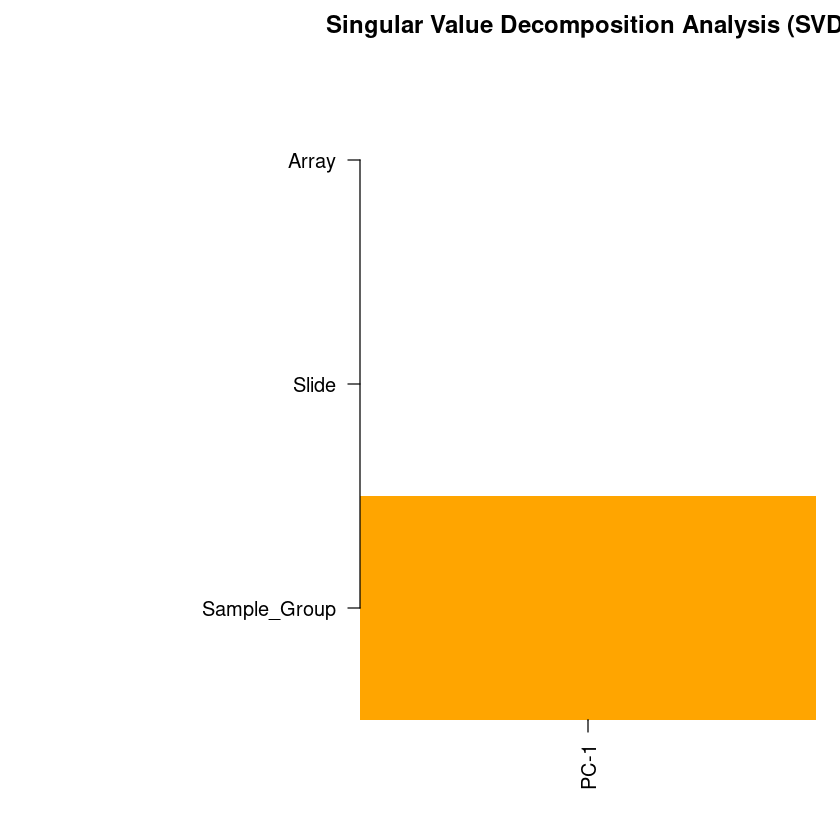

In [13]:
champ.SVD(beta=myCombat,pd=myLoad$pd)

### Bestimmung und Visualisierung von differentiell methylierten Sonden (DMPs)
<img controls src="../images/steps_10.png" />
</img>

Nach erfolgreichem Laden der Daten, anschließendem Normalisieren und dem entfernen von Batch-Effekten kann jetzt final die Methylierung zwischen Gruppen von Interesse verglichen werden.

Dafür nutzen wir `champ.DMP`, was die Methylierung jeder Sonde zwischen zwei Gruppen (hier Samplegroups) vergleicht und testet, ob der Unterschied der Methylierung der Sonde zwischen den gruppen statistisch signifikant ist. Dabei kann jeweils nur ein Vergleich zwischen zwei Gruppen stattfinden. Gibt es mehr als zwei Samplegroups, werden alle paarweisen Vergleiche berechnet.

Die Visualisierung erfolgt hier nicht über Plots, die im Notebook sichtbar sind, sondern über eine interaktive HTML Darstellung, die **über die angezeigte URL** erreichbar ist.

Die daraufhin angezeigte Seite beinhaltet verschiedene Elemente:
- **Eingabemaske (linker Rand)**: Hier müssen Nutzer einen **P-Cutoff** und einen **FoldChange** auswählen und auf **Submit** klicken, um DMPs anzeigen zu lassen. Über **Gene Symbol** kann man ein Gen auswählen, was daraufhin im Reiter **Gene** angezeigt wird. Über **CpG ID Symbol** kann man eine Sonde auswählen, die daraufhin im Reiter **CpG** einzeln angezeigt wird.
- **DMPtable**: Informationen zu den ausgewählten DMPs
- **Heatmap**: DMPs, die die SampleGroups am stärksten separieren
- **Feature&Cgi**: Positionen von DMPs in der DNA bzw. in CpG-Inseln
- **Gene**: Methylierung der DMPs eines Gens und Infos zu dem gewählten Gen
- **CpG**: Gene mit den meisten DMPs und einzelne CpGs

In [11]:
DMPs <- champ.DMP(beta = myNorm,pheno=myLoad$pd$Sample_Group, adjPVal = 0.05, arraytype = "EPICv2")
DMP.GUI(DMP=DMPs[[1]],beta=myNorm,pheno=myLoad$pd$Sample_Group)

[===========================]

[<<<<< ChAMP.DMP START >>>>>]

-----------------------------

!!! Important !!! New Modification has been made on champ.DMP(): 


    (1): In this version champ.DMP() if your pheno parameter contains more than two groups of phenotypes, champ.DMP() would do pairewise differential methylated analysis between each pair of them. But you can also specify compare.group to only do comparasion between any two of them.


    (2): champ.DMP() now support numeric as pheno, and will do linear regression on them. So covariates like age could be inputted in this function. You need to make sure your inputted "pheno" parameter is "numeric" type.


--------------------------------


[ Section 1:  Check Input Pheno Start ]


  You pheno is character type.

    Your pheno information contains following groups. >>

    <HeLa>:4 samples.

    <Raji>:4 samples.

    [The power of statistics analysis on groups contain very few samples may not strong.]

    pheno contains only 2

       Contrasts
Levels  pRaji-pHeLa
  pHeLa          -1
  pRaji           1


  You have found 561334 significant MVPs with a BH adjusted P-value below 0.05.

  Calculate DMP for HeLa and Raji done.


[ Section 2:  Find Numeric Vector Related CpGs Done ]



[ Section 3:  Match Annotation Start ]



[ Section 3:  Match Annotation Done ]


[<<<<<< ChAMP.DMP END >>>>>>]

[===========================]

[You may want to process DMP.GUI() or champ.GSEA() next.]


Lade nötiges Paket: shiny


Attache Paket: 'shiny'


Die folgenden Objekte sind maskiert von 'package:DT':

    dataTableOutput, renderDataTable



Listening on http://127.0.0.1:3236

56133419

<< Generating dmrplot >>

<< Dots Plotted >>

<< Mean line Plotted >>

<< Loess line Plotted >>

<< Cgi Bar Plotted >>

<< Generating dmrplot >>

<< Dots Plotted >>

<< Mean line Plotted >>

<< Loess line Plotted >>

<< Cgi Bar Plotted >>

<< Generating dmrplot >>

Warning message:
"Error in data.frame: Argumente implizieren unterschiedliche Anzahl Zeilen: 0, 1"
<< Generating dmrplot >>

Warning message:
"Error in data

### Bestimmung und Visualisierung von differentiell methylierten Regionen (DMRs)
Nach der Evaluation von DMPs können diese zu DMRs zusammengefasst werden. Eine DMR ist eine Region, in der sich besonders viele DMPs befinden.

Die Visualisierung ist ähnlich der von DMPs in verschiedene Elemente aufgeteilt:
- **Eingabemaske (linker Rand)**: Hier müssen Nutzer einen **P-Cutoff** und eine Mindestanzahl an enthaltenen DMPs angeben werden, um das Set der gefundenen DMRs vorzufiltern. Über den **DMR-Index** kann eine einzelne DMR anhand ihrer **ID** in **DMRtable** ausgewählt werden. Die gewählte DMR wird dann im **DMRPlot** visualisiert
- **DMRtable**: Zeigt die ausgewählten DMRs und viele Zusatzinformationen an
- **CpGtable**: Durchsuchbare DMP Tabelle in der die Zuordnung der DMPs zu den DMRs einsehbar ist. Sehr praktisch, um DMRs zu suchen, die ein bestimmtes Gen enthalten, da **gene** nur in CpGtable enthalten ist
- **DMRPlot**: Anzeige einer bestimmten DMR nach Selektion über die **Eingabemaske**
- **Summary**: Zeigt die Gene an, für die die meisten CpGs in einer oder mehrerer DMRs liegen, sowie der DMP-Status dieser CpGs. Zusätzlich sind die größten Methylierungsunterschiede zwischen CpGs in DMRs der **Sample_Groups** dargestellt

In [15]:
DMRs <- champ.DMR(beta=myNorm,pheno=myLoad$pd$Sample_Group,method="Bumphunter", arraytype="EPICv2")
DMR.GUI(DMR=DMRs, arraytype="EPICv2")

[===========================]

[<<<<< ChAMP.DMR START >>>>>]

-----------------------------

!!! important !!! We just upgrate champ.DMR() function, since now champ.DMP() could works on multiple phenotypes, but ProbeLasso can only works on one DMP result, so if your pheno parameter contains more than 2 phenotypes, and you want to use ProbeLasso function, you MUST specify compare.group=c("A","B"). Bumphunter and DMRcate should not be influenced.


[ Section 1:  Check Input Pheno Start ]


  You pheno is character type.

    Your pheno information contains following groups. >>

    <Cellline>:12 samples.

    <Coriell>:4 samples.


[ Section 1:  Check Input Pheno Done ]



[ Section 2:  Run DMR Algorithm Start ]


<< Find DMR with Bumphunter Method >>

3 cores will be used to do parallel Bumphunter computing.

According to your data set, champ.DMR() detected 11309 clusters contains MORE THAN 7 probes within 300 maxGap. These clusters will be used to find DMR.


[bumphunterEngine] Paralle

           Contrasts
Levels      pCoriell-pCellline
  pCellline                 -1
  pCoriell                   1


  You have found 832552 significant MVPs with a BH adjusted P-value below 1.

  Calculate DMP for Cellline and Coriell done.


[ Section 2:  Find Numeric Vector Related CpGs Done ]



[ Section 3:  Match Annotation Start ]



[ Section 3:  Match Annotation Done ]


[<<<<<< ChAMP.DMP END >>>>>>]

[===========================]

[You may want to process DMP.GUI() or champ.GSEA() next.]



[ Section 1: Calculate DMP Done  ]



[ Section 2: Mapping DMR to annotation Start  ]


  Generating Annotation File

  Generating Annotation File Success


[ Section 2: Mapping DMR to annotation Done  ]



Listening on http://127.0.0.1:6792

<< Generating dmrplot >>



[1] 10560    11


<< Calculating Gene Enrich Plot >>

<< Generating dmrplot >>

<< Dots Plotted >>

<< Mean line Plotted >>

<< Loess line Plotted >>

<< Cgi Bar Plotted >>

